# Test Sequences Lab Book

## Objective: Document process of creating 1st batch of test sequences

## Rik Khot
## Cardiff University School of Physics & Astronomy
## Supervisors: Kevin Murphy, Ian Driver, Emre Kopanoglu
## May 2025 

# Introduction


## Aims

I will create a batch of test sequences to trial on the Siemens 3T PRISMA. These are the following aims of these tests:

- To learn how to navigate loading pulseq files onto a Siemens MR Scanner
- To investigate alternative open-source pulse sequences for DIMAC (as opposed to Siemens pre-made sequences)
- To gather information on product specifications for 3T PRISMA (so these can be hard coded into pulseq files)
- To incorporate existing image reconstruction techniques (SENSE/GRAPPA) within pulseq scripts

## The Test Sequence list (subject to change)

- EPI
- EPI (with spoiled gradients)
- Radial
- Golden angle Radial
- Spiral

- EPI Undersampled
- Radial Undersampled
- Spiral Undersampled

### An Aside: Filing Convention

Files will be saved with the following naming convention:

**SEQTYPE_TRVal_Undersampled.py**

e.g.1. EPI_14ms.py for EPI that is **not undersampled**
e.g.2. EPI_14ms_U.py for EPI that is **undersampled**

## DIMAC Criteria
Dynamic Inflow MAgnitude Contrast (DIMAC) requires an ultra-fast TR. We require $TR \le 15ms$

DIMAC measure real-time pulsatile flow into a slice. The aim is to "dull down" all other signals, so that fresh signals entering a slice have a high signal intensity w.r.t the rest of the slice componants.

The main advantage of DIMAC is that is does not require Motion Encoding Gradients and uses the natural phenomena of the inflow effect to observe new flow entering a slice across an artery.

Therefore we define the following criteria:

- $TR \le 15ms$
- Pulse sequence supresses all signal within slice (so that new signals are clearly observed)
- Single Slice
- EPI: single-shot
- Radial: one spoke every 15ms

## 3T Siemens PRISMA Specifications


### Reasoning for acquiring information
Within Pulseq code we have a section of code defining system limits:

In [1]:
import pypulseq as pp
# Set system limits
system = pp.Opts(
    max_grad=32,
    grad_unit='mT/m',
    max_slew=130,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    )

However as of writing (23/05/25) we do not know if this matches the Siemens 3T PRISMA specifications. So let's find out.

### The Specifications
*Source: [Siemens Healthineers Website](https://www.siemens-healthineers.com/magnetic-resonance-imaging/3t-mri-scanner/magnetom-prisma)*
- Maximum Gradient Amplitude = **139 mT/m**
- Maximum Slew Rate = **346 T/m/s**
- RF Ringdown Time = **?**
- RF Dead Time = **?**
- FOV = **0.125 m^3**

**Note: Pulseq update now means FOV is read in meters**

*Source: [Pulseq Github](https://github.com/pulseq/pulseq/blob/master/doc/pulseq_shapes_and_times.pdf)*

**Raster Time Definitions** (already pre-defined with Siemens parameters in pulseq)

- Gradient Raster Time = **10us**
- RF Raster Time = **1us**
- ADC Raster Time = **100ns**

## Simulations with Koma MRI

Koma MRI is a package written in Julia, which simulates the resultant K-space data and image reconstruction from a given pulseq file. 

**Note: Koma MRI simulations shown in this document do NOT consider inflow effect**

In future, we will need to consider adding inflow effects to our Koma MRI simulations, for a better prediction of MR reconstruction images for test pulse sequences.

## SAR Limitations

The Specific Absorbsion rate accepted for MRI is 

**Head** = 3.2 W/kg
**Full Body** = 2 W/kg

We are looking at SAR for head since we will only be using neuroimaging protocals? Is this correct - check!

As I am in favour of DIMAC for clinical applicability, we will not consider 1st level and 2nd level SAR values.

**Disclaimer**: I am unsure what values of head and body mass are being used by pulseq to generate the Q matrix for SAR.

In [ ]:
#within main function added additional sar variable -UPDATED CODE 09/06/2025

if sar:
       #loadQ creates matrix of sar values 
        Qtmf, Qhmf = _load_Q()
        sar_values = SAR(seq, Qtmf, Qhmf)
        sar_values_array = np.column_stack((sar_values[0], sar_values[1], sar_values[2]))

        headers = ["Body mass SAR", "Head mass SAR", "time"]
        sar_values_table = pd.DataFrame(sar_values_array, columns=headers)
        sar_values_table.to_csv('SAR.csv', index=False)
        
        #SAR checker - print statement will only been shown if SAR is violated for either head or body
        violation_1 = False
        violation_2 = False
    # Head SAR validation
        for i in sar_values_table.iloc[:, 1]:
            if (i >= 3.2):
                print("SAR head value NOT acceptable")
                violation_1 = True
                break
        #Validation for full body mass SAR
        for j in sar_values_table.iloc[:, 0]:
            if (j > 2):
                print("SAR Body value NOT acceptable")
                violation_2 = False
                break


# EPI

Here we will explore the simplest EPI file on pypulseq. Original file is **write_epi.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_epi_rk.py** (a file where I can play around with parameters) which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.


## EPI, TR = 14ms

*Variable change: Nx and Ny = 32*

Hypothesis: because of the extremely small matrix size, I expect the image to have many artefacts

FILENAME: epi_14ms.py
    
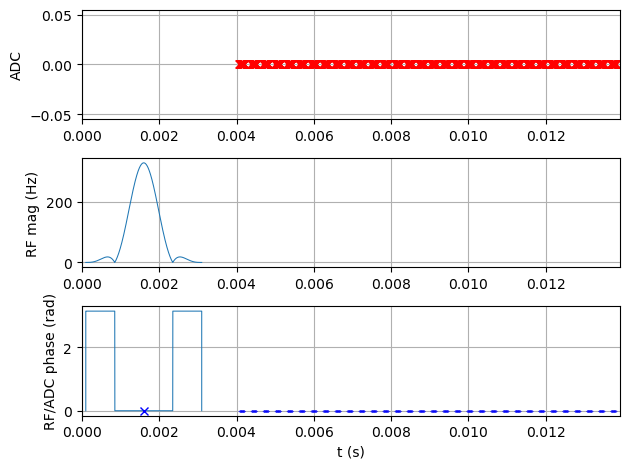
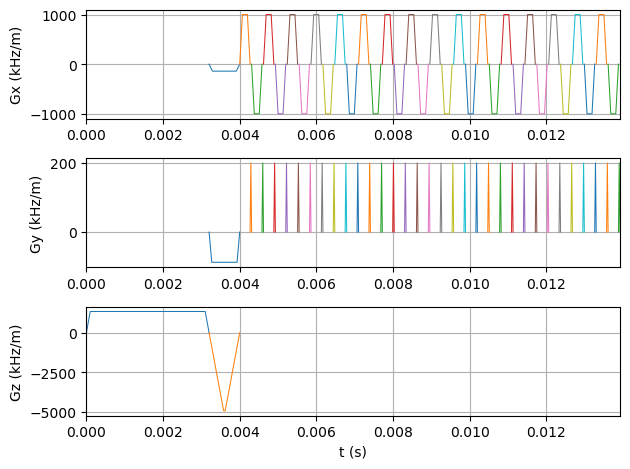



### Results 

#### KomaMRI (Simulated results)


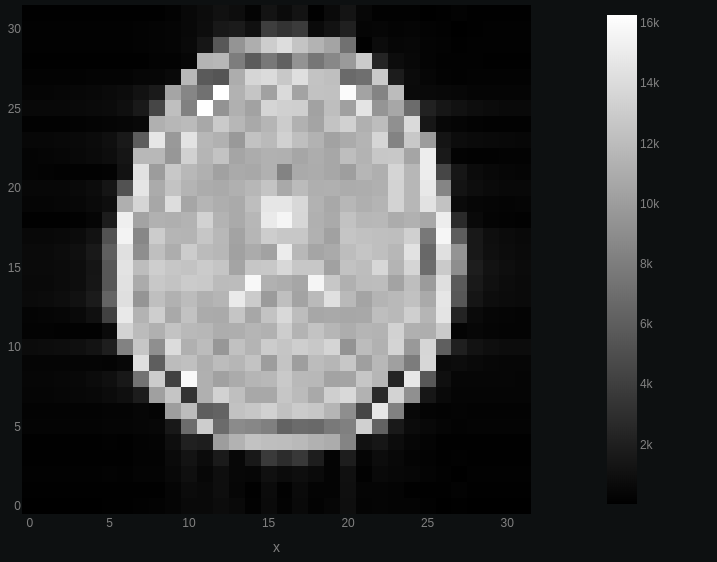

As you can see the reduced Matrix size has lowered the image quality, as the slice is of a very low resolution.

#### 3T MRI Result




## EPI, TR = 32ms

*Variable change: Nx and Ny = 64*

Hypothesis: Image quality will be fair, however for blood pulsatility the TR is way too long => not useful for DIMAC?

FILENAME: epi_32ms.py

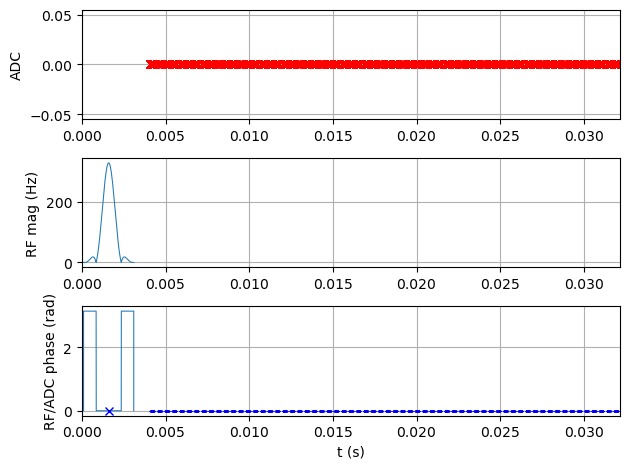
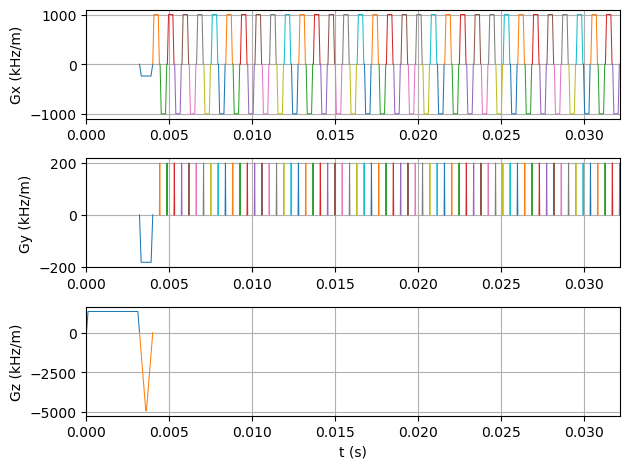

### Results 

#### KomaMRI (Simulated Results)

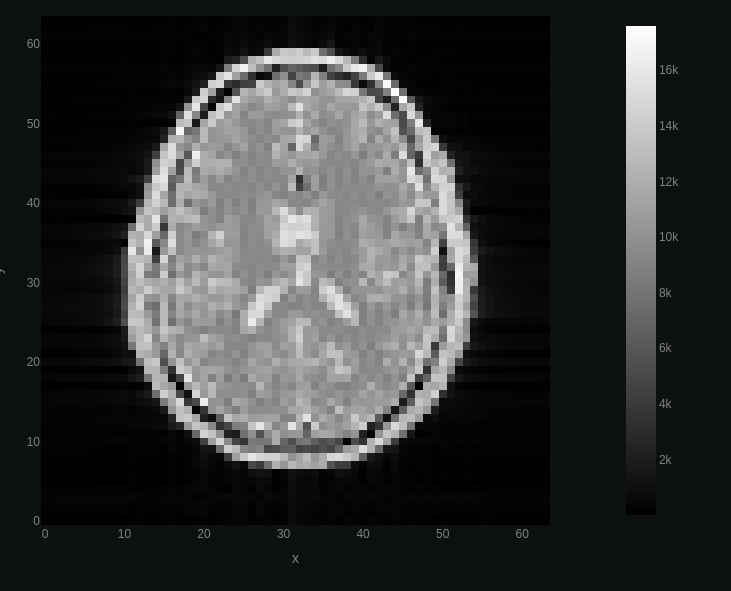

As you can see by having a matrix size of 64 the image resolution has improved, however at the cost of a longer TR, meaning the inflow "pulse" will likely be affected by the RF pulse causing loss of T1 magnetisation.

#### MRI Results




# EPI (Spoiled Gradients)
Here we will explore the spoiled gradients EPI file on pypulseq. Original file is **write_epi_se.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_epi_se_rk.py** which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.

## EPI Spoiled, TR = 46ms

Variable changes:
- Nx, Ny = 32
- TE = $37e-4$
- pre-time = $5e-4$
- RF 180 pulse duration = $100e-6$
- RF dead time = $100e-5$

Hypothesis: Image quality will be bad

Note: Found it very difficult to decrease TR significantly

FILENAME: epi_se_46ms.py

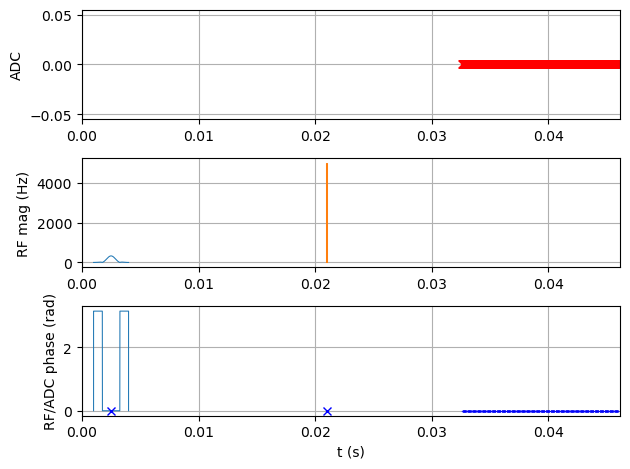
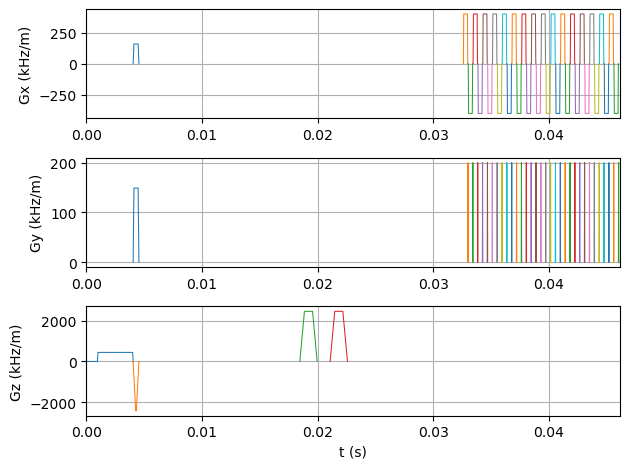


### Results 

#### KomaMRI (Simulated results)

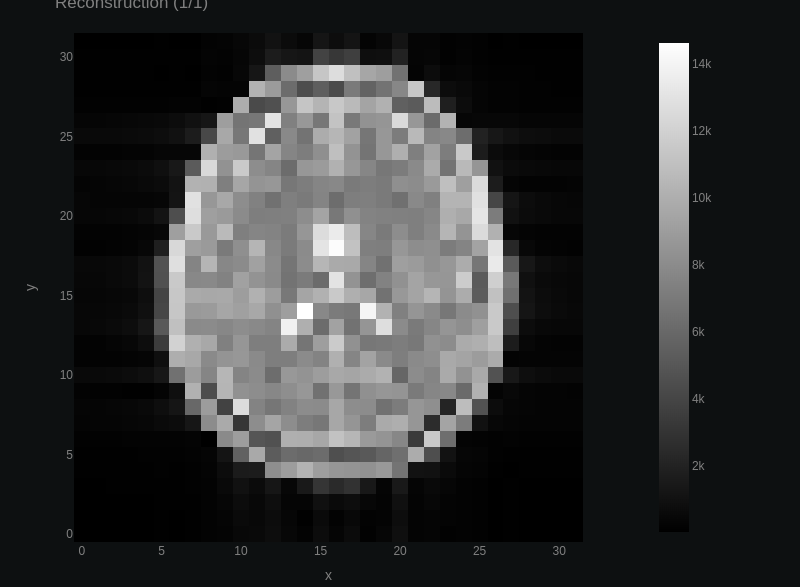

Here the matrix size is very small (N=32) and that hugely affects the image resolution.


#### 3T MRI Result



# Radial

Here we will explore the simplest Gradient Recalled Echo Radial file on pypulseq. Original file is **write_radial_gre.py**. I have made edits in line with the DIMAC and Siemens 3T PRISMA criteria, on a new file named **write_radial_gre_rk.py**( a file where I can play around with parameters) which can be found on my private Git branch.

Here I will change parameters to shorten TR as much as possible **without undersampling**.

## Radial, Total Time = 44ms

Variable changes:

- Flip Angle, Alpha = 90
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- Nr = 4
- N_dummy = 0
- $\delta = \frac{\pi}{Nr}$

Nr, N_dummy and TR seemed to reduce the Total scan time dramatically.

I expect the image to be sparse due to there being only 4 radial spokes.

FILENAME: gre_radial_44ms.py

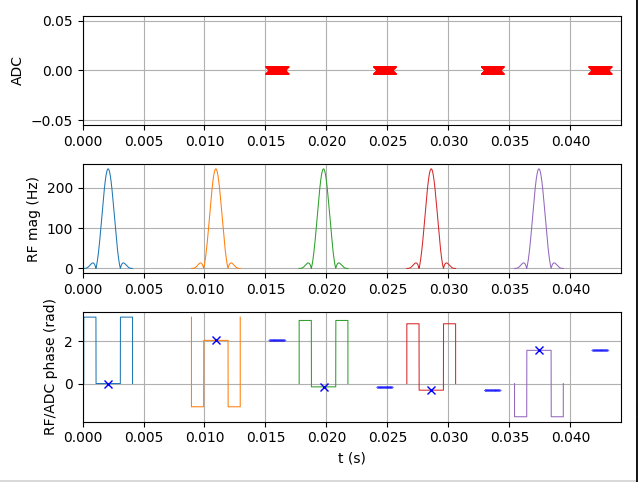
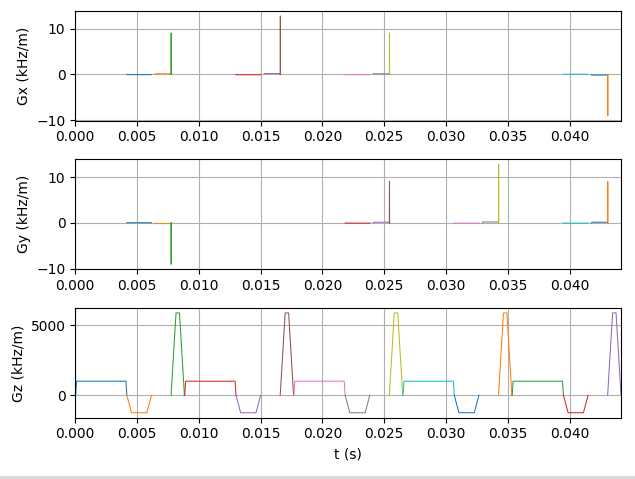


### Results

#### KomaMRI (Simulated)

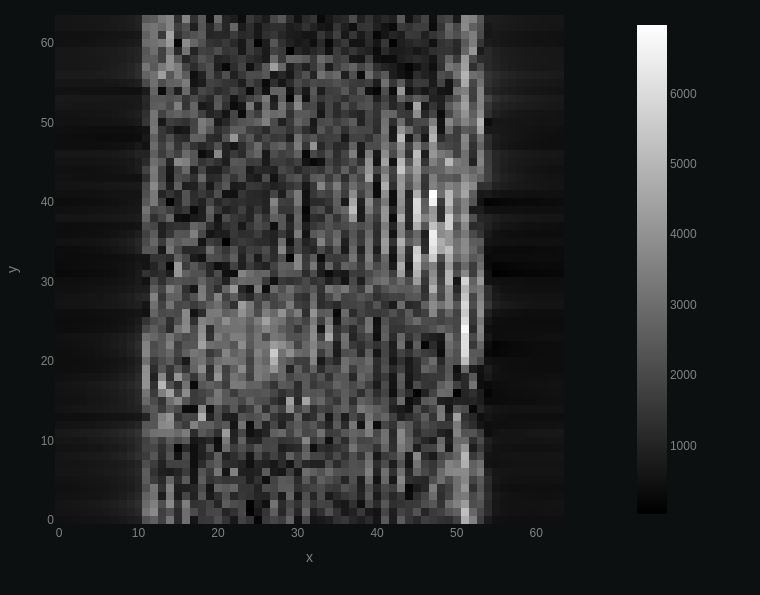

To put it simply this is an absolutely rubbish image, very sparse K-space coverage.

#### 3T MRI



## Radial, Total Time = 185ms
Variable changes:

- Flip Angle, Alpha = 90
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- Nr = 20
- N_dummy = 0
- $\delta = \frac{\pi}{Nr}$
Hope that this improves signal/image quality.


FILENAME: gre_radial_185ms.py

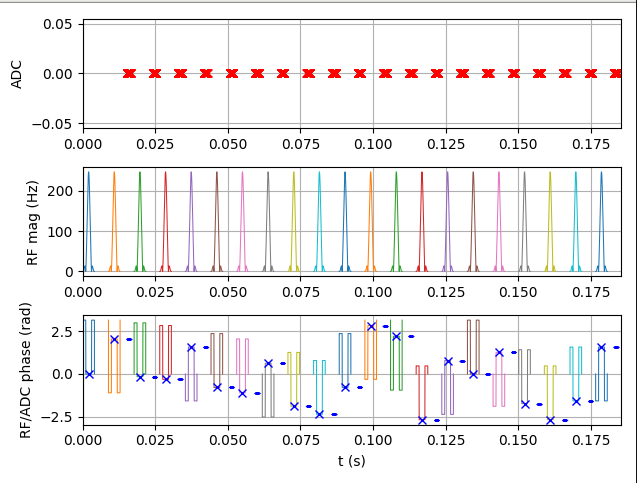
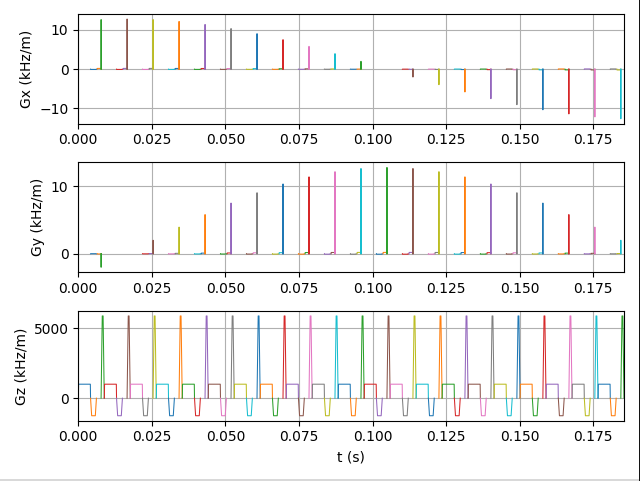


### Results
#### KomaMRI (Simulation)

KomaMRI seems to be struggling to make an image simulation, unsure whether this is because of the pulseq file or errors outside of this. I'm hoping that this is a problem with how KomaMRI deals with radial acquisitions.

As of 29/05/25, we have no KomaMRI image.

#### 3T MRI Result

# Golden Angle Radial

This type of K-space sampling uses the golden ratio/fibonnaci to try to quicken image acquisition time whilst retaining image quality. [source: Feng,L.(2022)](https://onlinelibrary.wiley.com/doi/full/10.1002/jmri.28187). 

*Trial: using fibbonacci numbers as spoke numbers and see if that does anything*

FILENAME for test environemnt: **write_radial_goldenangle_gre_rk.py**

## Half Spoke (No dummy scans)
Below are the parameters for a half spoke radial pulse sequences.

**Angular increment, $\delta = 137.51^\circ$**
- alpha = $90^\circ$
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- N_dummy = 0
- gx: flat_area = $\frac{Nx}{2} * \delta_{k}$
- gx_spoil: area = $0.5*\frac{Nx}{2}*\delta_{k}$

Note: Nr is the number of radial spokes. T is the total time for image acquisition.

### Nr = 5, T = 50ms
FILENAME for sequence: ***gre_radial_golden_half_50ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

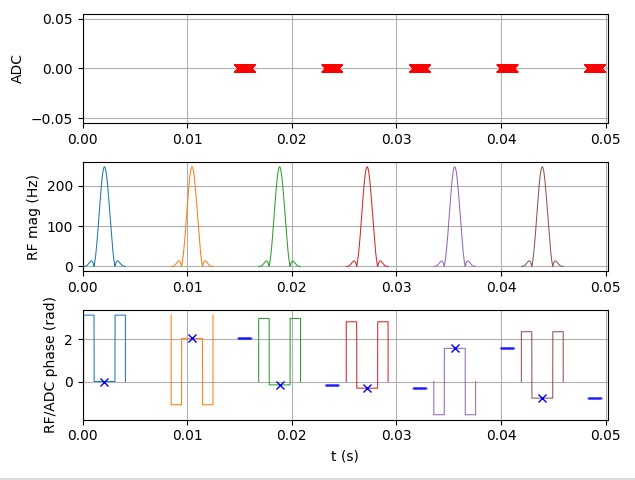
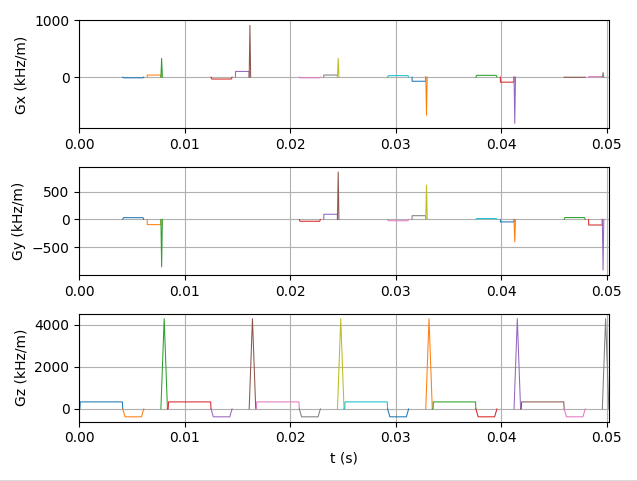



### Nr = 8, T = 79ms
FILENAME for sequence: **gre_radial_golden_half_79ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

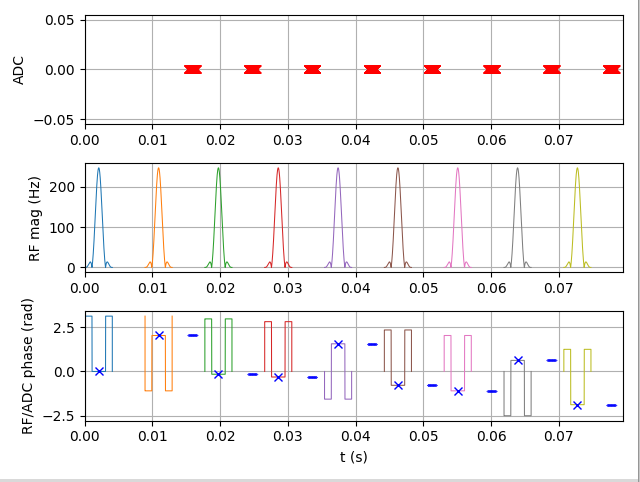
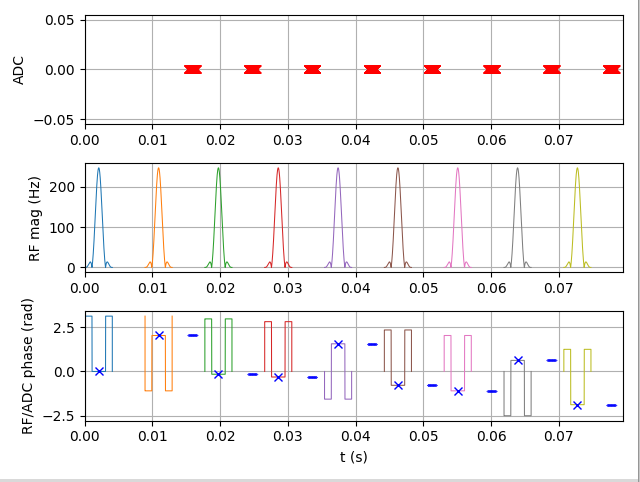

I am unsure why between 0.1s and 0.2s there is no Gy?


### Nr = 13, T = 124ms
FILENAME for sequence: **gre_radial_golden_half_124ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

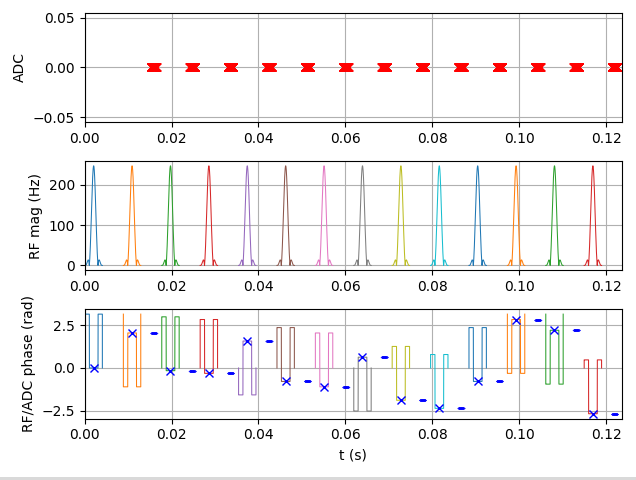
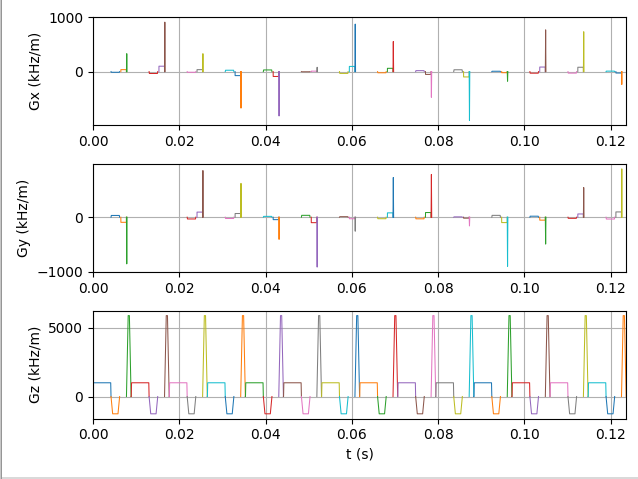
### Nr = 20, T = 185ms
FILENAME for sequence: **gre_radial_golden_half_185ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

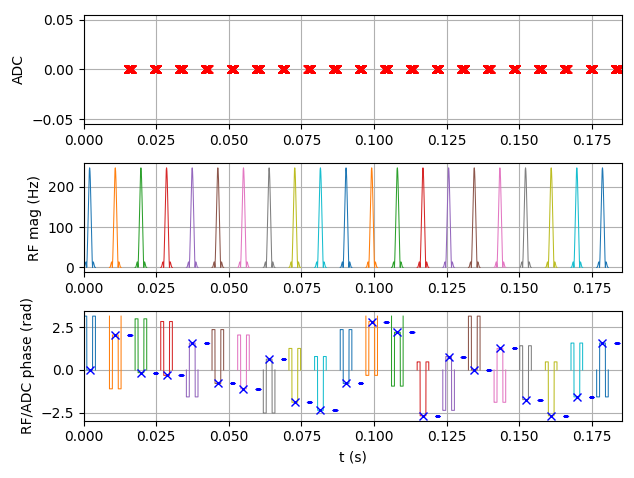
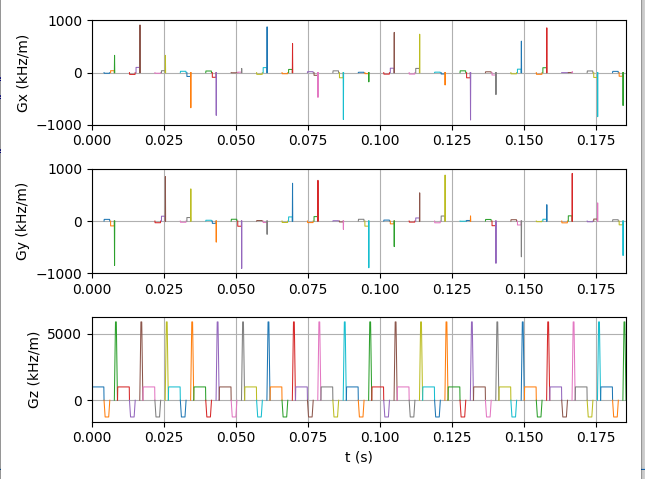
### Nr = 21, T = 194ms 
FILENAME for sequence: **gre_radial_golden_half_194ms.seq**
- SAR head: acceptable
- SAR body: unacceptable
  
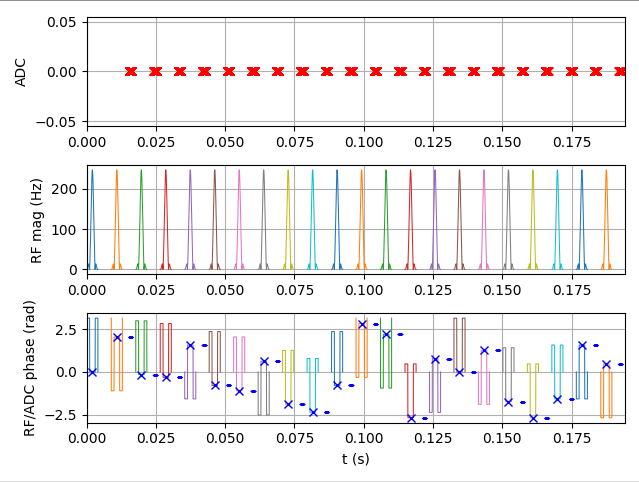
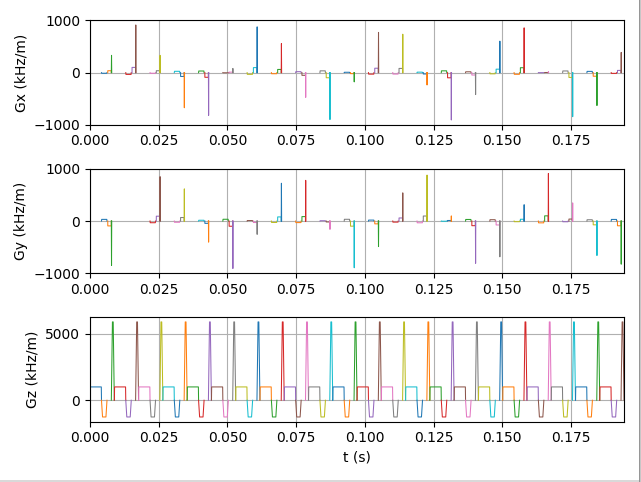

### Nr = 60, T = 539ms
FILENAME for sequence: **gre_radial_golden_half_539ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

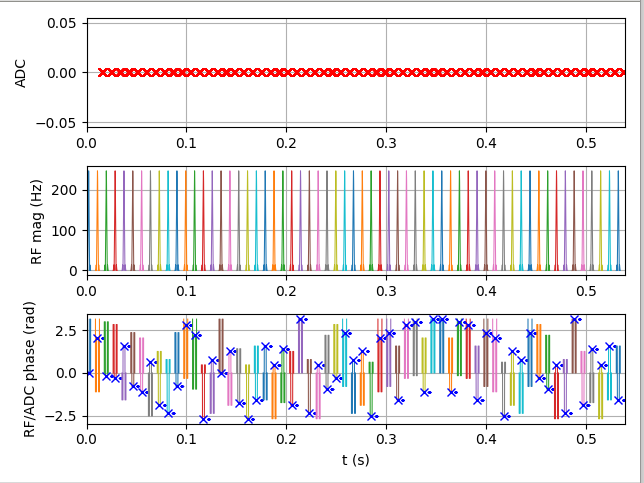
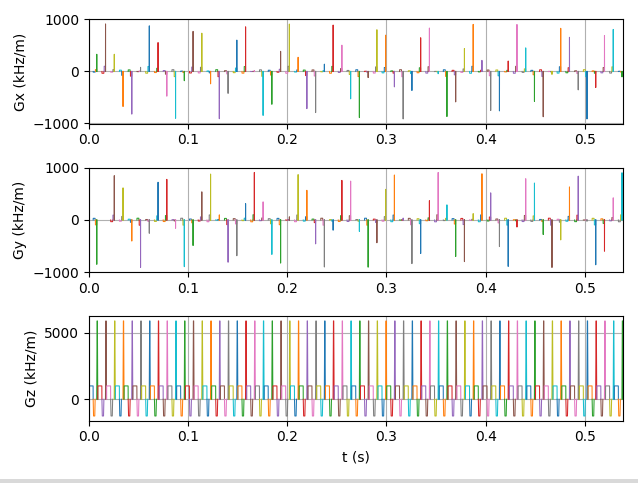


### Nr = 100, T = 892ms
FILENAME for sequence: **gre_radial_golden_half_892ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

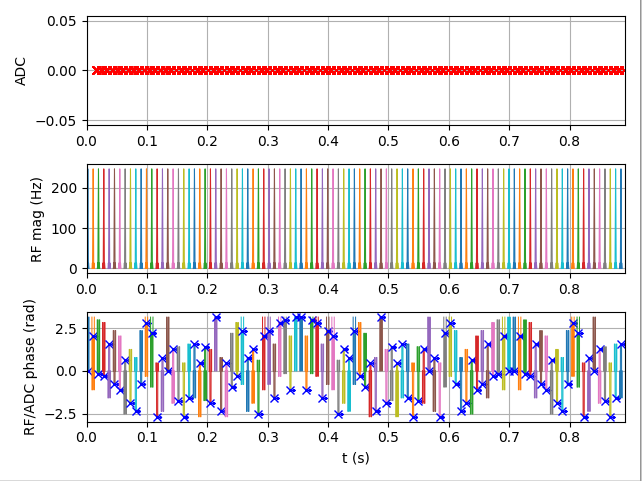
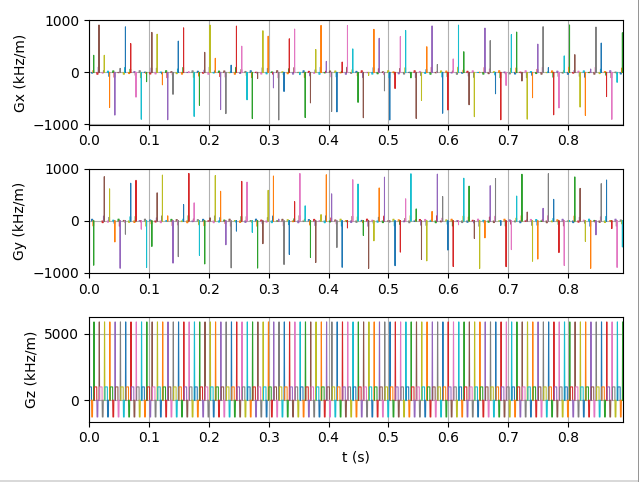

### Results
#### KomaMRI
It's shit but I'm unsure why - may bc it doesn't consider inflow effect??

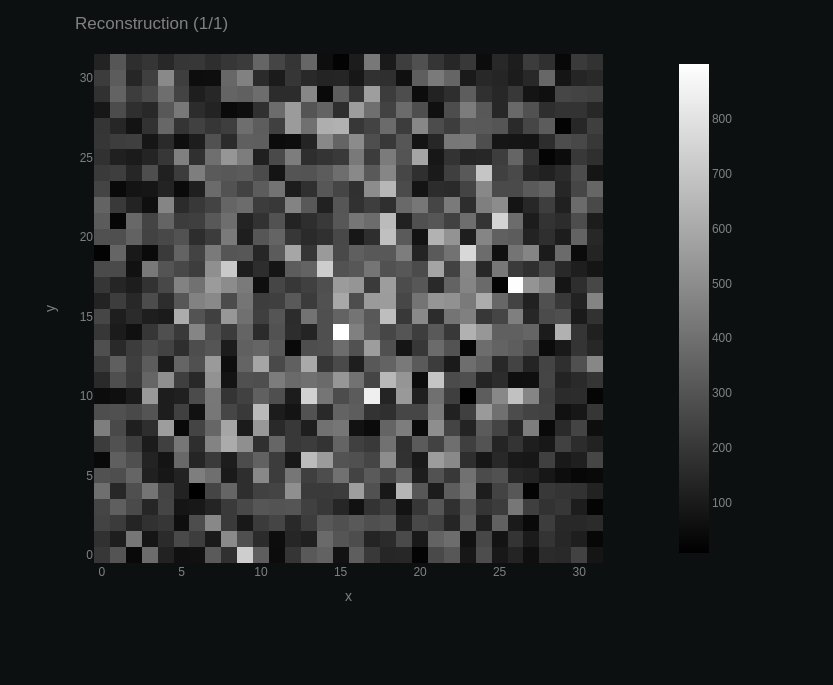

## Half Spoke (20 dummy scans)

The parameters:

**Angular increment, $\delta = 137.51^\circ$**
- alpha = $90^\circ$
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- N_dummy = 20
- gx: flat_area = $\frac{Nx}{2} * \delta_{k}$
- gx_spoil: area = $0.5*\frac{Nx}{2}*\delta_{k}$


### Nr = 21, T = 371ms
FILENAME for sequence: **gre_radial_golden_half_371ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

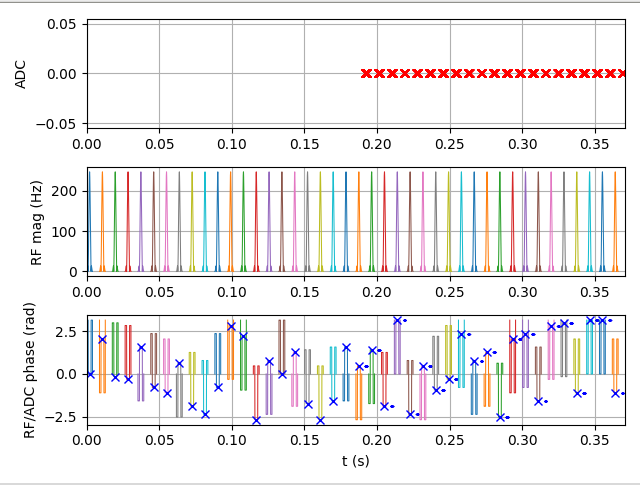
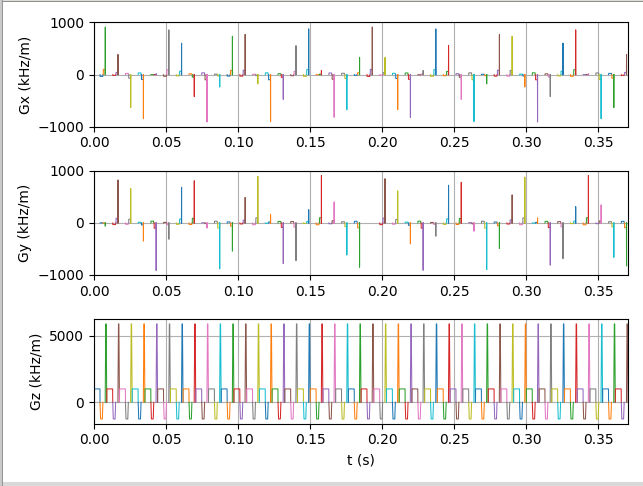


### Nr = 60, T = 715ms
FILENAME for sequence: **gre_radial_golden_half_715ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

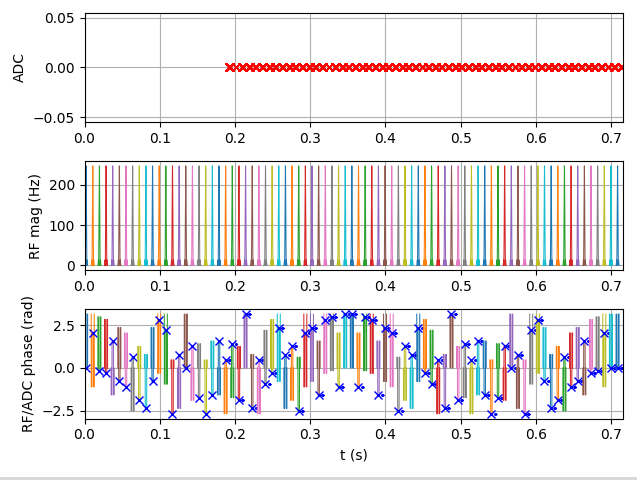
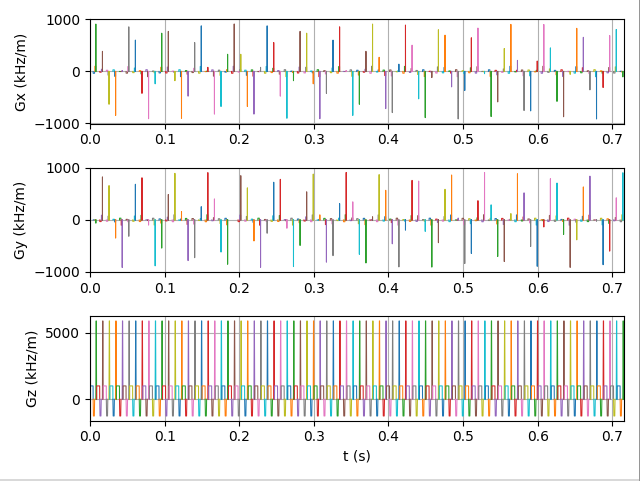

### Nr = 100, T = 1.07s
FILENAME for sequence: **gre_radial_golden_half_1070ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

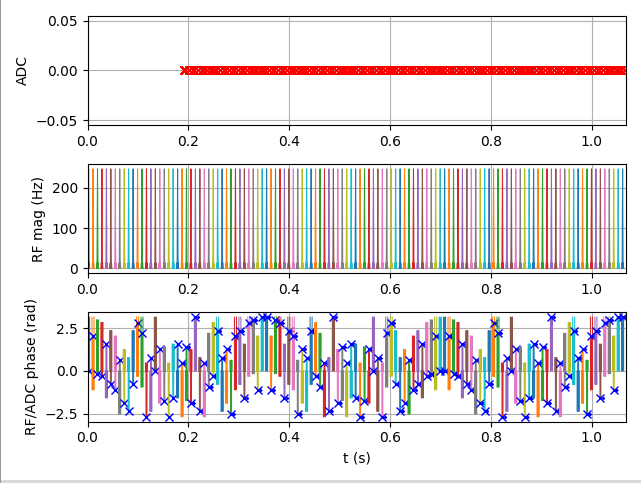
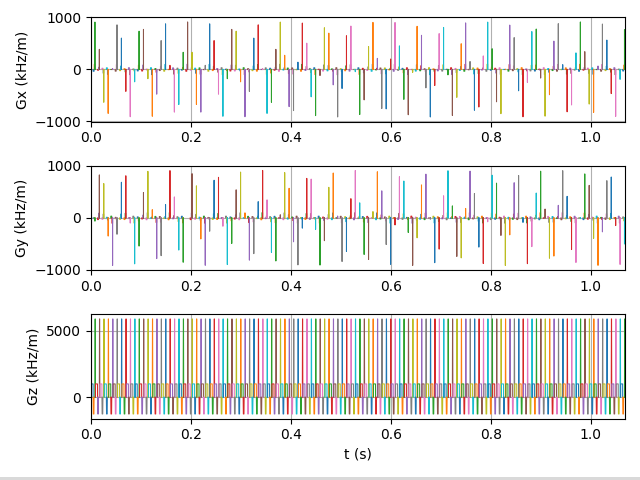

#### Results KomaMRI

Results are shite - it's not worth putting them on here. Consider factoring in in-flow effects, to give more "realistic"/"relevent" simulation.

## Full spoke (20 dummy scans)

**Angular increment, $\delta = 111.25^\circ$**
- alpha = $90^\circ$
- slice thickness = 1e-3
- TE = 5e-3
- TR = 7.8e-3
- N_dummy = 20
- gx: flat_area = $\frac{Nx}{2} * \delta_{k}$
- gx_spoil: area = $0.5*\frac{Nx}{2}*\delta_{k}$

### Nr = 21, T = 372ms

FILENAME for sequence: **gre_radial_golden_full_372ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

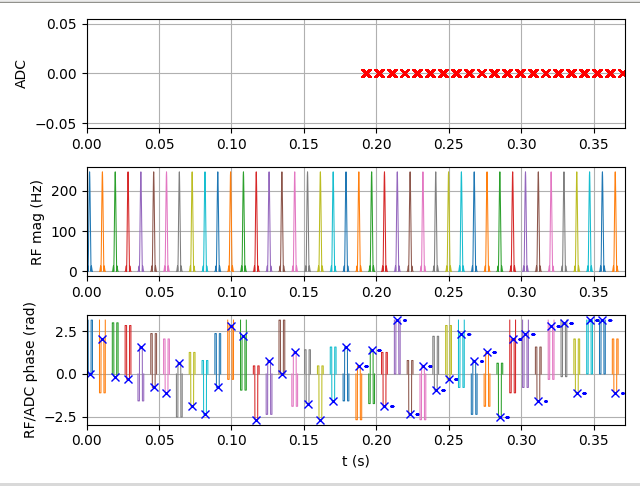
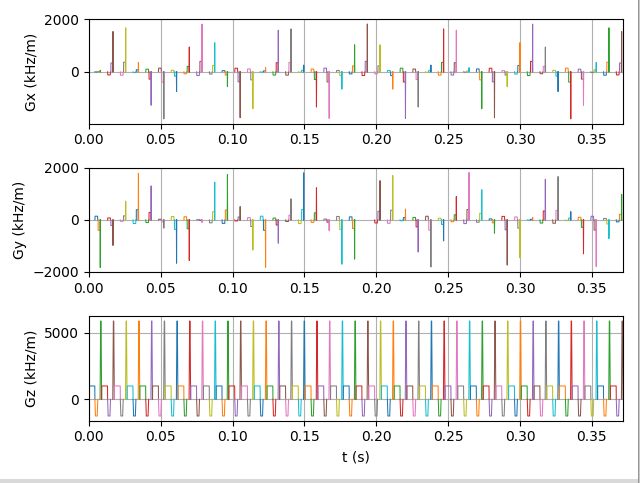

### Nr = 60, T = 717ms

FILENAME for sequence: **gre_radial_golden_full_717ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

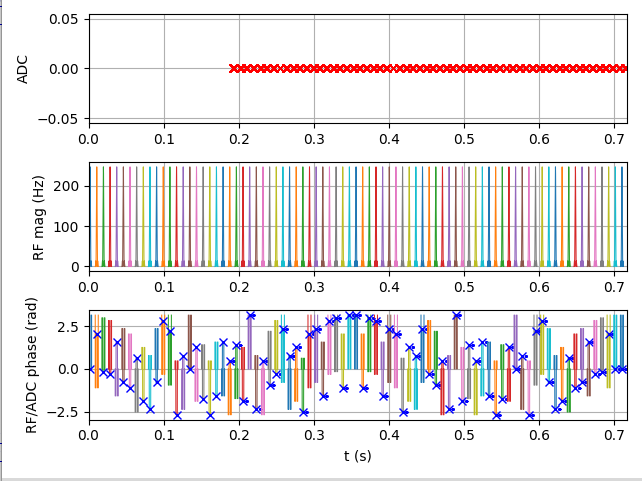
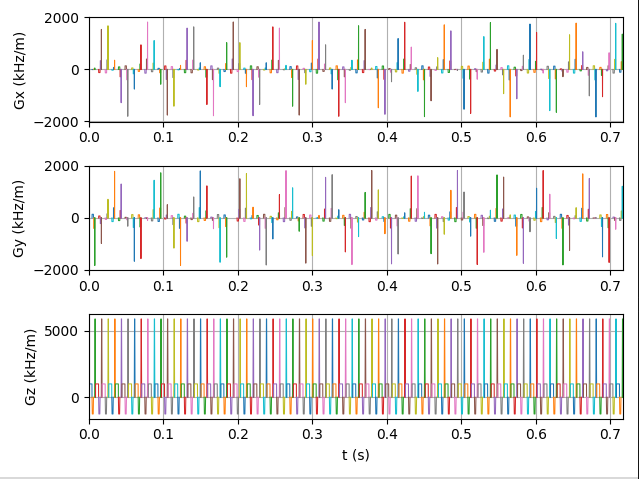

### Nr = 100, T = 1071ms

FILENAME for sequence: **gre_radial_golden_full_1071ms.seq**
- SAR head: acceptable
- SAR body: unacceptable

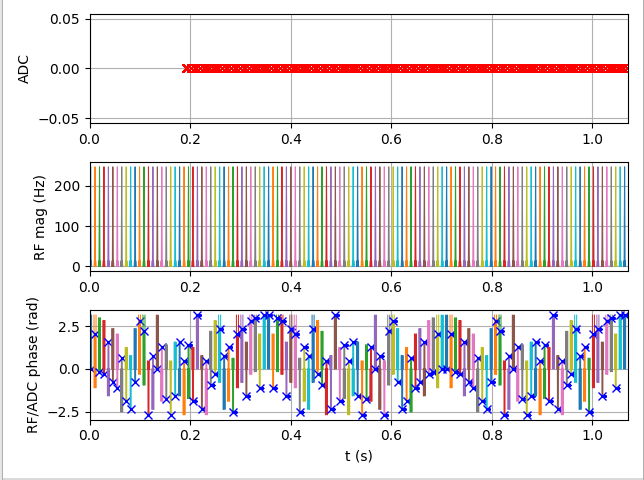
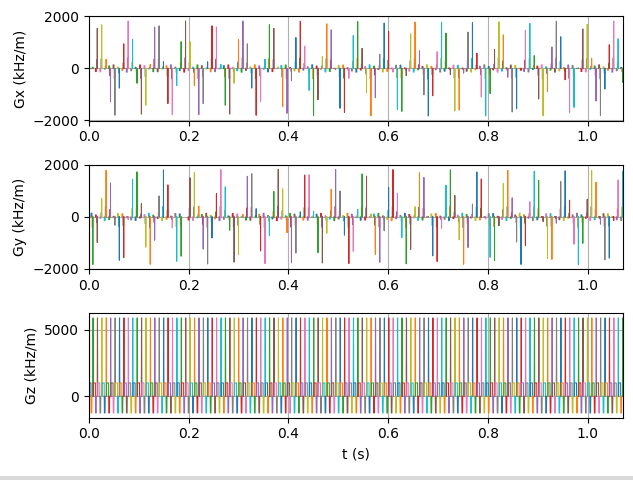



# Spiral

Spiral sequence generated from matlab code (accessed from pulseq git)
## Standard Spiral

f courses you would be interested in demonstrating, and then they should follow up a month later if they can't fill all the slots and need more people for specific modules.
## Fibonnacci Spiral

# Image Reconstruction Steps

## Fully sampled data sets
- Identify image reconstruction techniques for EPI
- Identify image reconstruction techniques for radial and spiral data
- Perform image reconstruction techniques

## Undersampled data sets
- Identify image reconstruction techniques for EPI
- Identify image reconstruction techniques for radial and spiral data
- Perform image reconstruction techniques